# Overview

## Description

This challenge serves as final project for the "[How to win a data science competition](https://www.coursera.org/learn/competitive-data-science/home/welcome)" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - [1C Company](http://1c.ru/eng/title.htm). 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

## Evaluation

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

**Submission File**

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:

```
ID,item_cnt_month
0,0.5
1,0.5
2,0.5
3,0.5
etc.
```|

---

# Data Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions

- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

## Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category
- This dataset is permitted to be used for any purpose, including commercial use.

# Import library

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np

# 데이터 결측치 확인
import missingno as msno

# models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
column_order = ['date_block_num', 'year', 'month',
                'shop_id', 'item_category_id', 'item_id']
random_state = 0

In [56]:
def plotting_3_chart(df, feature):
    # Importing seaborn, matplotlab and scipy modules.
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(15, 10))
    # creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature], norm_hist=True, ax=ax1)

    # customizing the QQ_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('QQ_plot')
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature], plot=ax2)

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3)

# Understanding the data

## Load data

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_predict_future_sales/data'

sales_train_path = join(data_dir, 'sales_train.csv')
items_path = join(data_dir, 'items.csv')
test_path = join(data_dir, 'test.csv')

sales_train = pd.read_csv(sales_train_path)
items = pd.read_csv(items_path)
test = pd.read_csv(test_path)

In [5]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [6]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [7]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


# Data preprocessing

## sales_data preprocessing

In [8]:
# 원본 유지를 위해 data로 복사
data = sales_train.copy()
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [9]:
# date preprocessing
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [10]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
del data['date']
data

,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month
0,0,59,22154,999.00,1.0,2013,1
1,0,25,2552,899.00,1.0,2013,1
2,0,25,2552,899.00,-1.0,2013,1
3,0,25,2554,1709.05,1.0,2013,1
4,0,25,2555,1099.00,1.0,2013,1
...,...,...,...,...,...,...,...
2935844,33,25,7409,299.00,1.0,2015,10
2935845,33,25,7460,299.00,1.0,2015,10
2935846,33,25,7459,349.00,1.0,2015,10
2935847,33,25,7440,299.00,1.0,2015,10


In [11]:
data_add = data.copy()

In [12]:
# date, shop, item으로 묶어 월판매량을 구한다.
data = data.groupby(['date_block_num', 'shop_id', 'item_id'],
                    as_index=False).agg({'item_cnt_day': sum})
data

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [13]:
# column 이름 정리
data.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
data

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [14]:
# category_id를 추가하고 item_name은 삭제
data = pd.merge(data, items, on='item_id', how='left')
del data['item_name']
data

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57
...,...,...,...,...,...
1609119,33,59,22087,6.0,83
1609120,33,59,22088,2.0,83
1609121,33,59,22091,1.0,83
1609122,33,59,22100,1.0,42


In [15]:
# year, month, price 추가
data = pd.merge(data, data_add,
                on=['date_block_num', 'shop_id', 'item_id'], how='left')
del data['item_cnt_day']
del data['item_price']
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,year,month
0,0,0,32,6.0,40,2013,1
1,0,0,32,6.0,40,2013,1
2,0,0,32,6.0,40,2013,1
3,0,0,32,6.0,40,2013,1
4,0,0,33,3.0,37,2013,1


In [16]:
# merge가 잘 수행됐는지 확인
data[(data['shop_id'] == 59) & (data['item_id'] == 22154)]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,year,month
115689,0,59,22154,1.0,37,2013,1


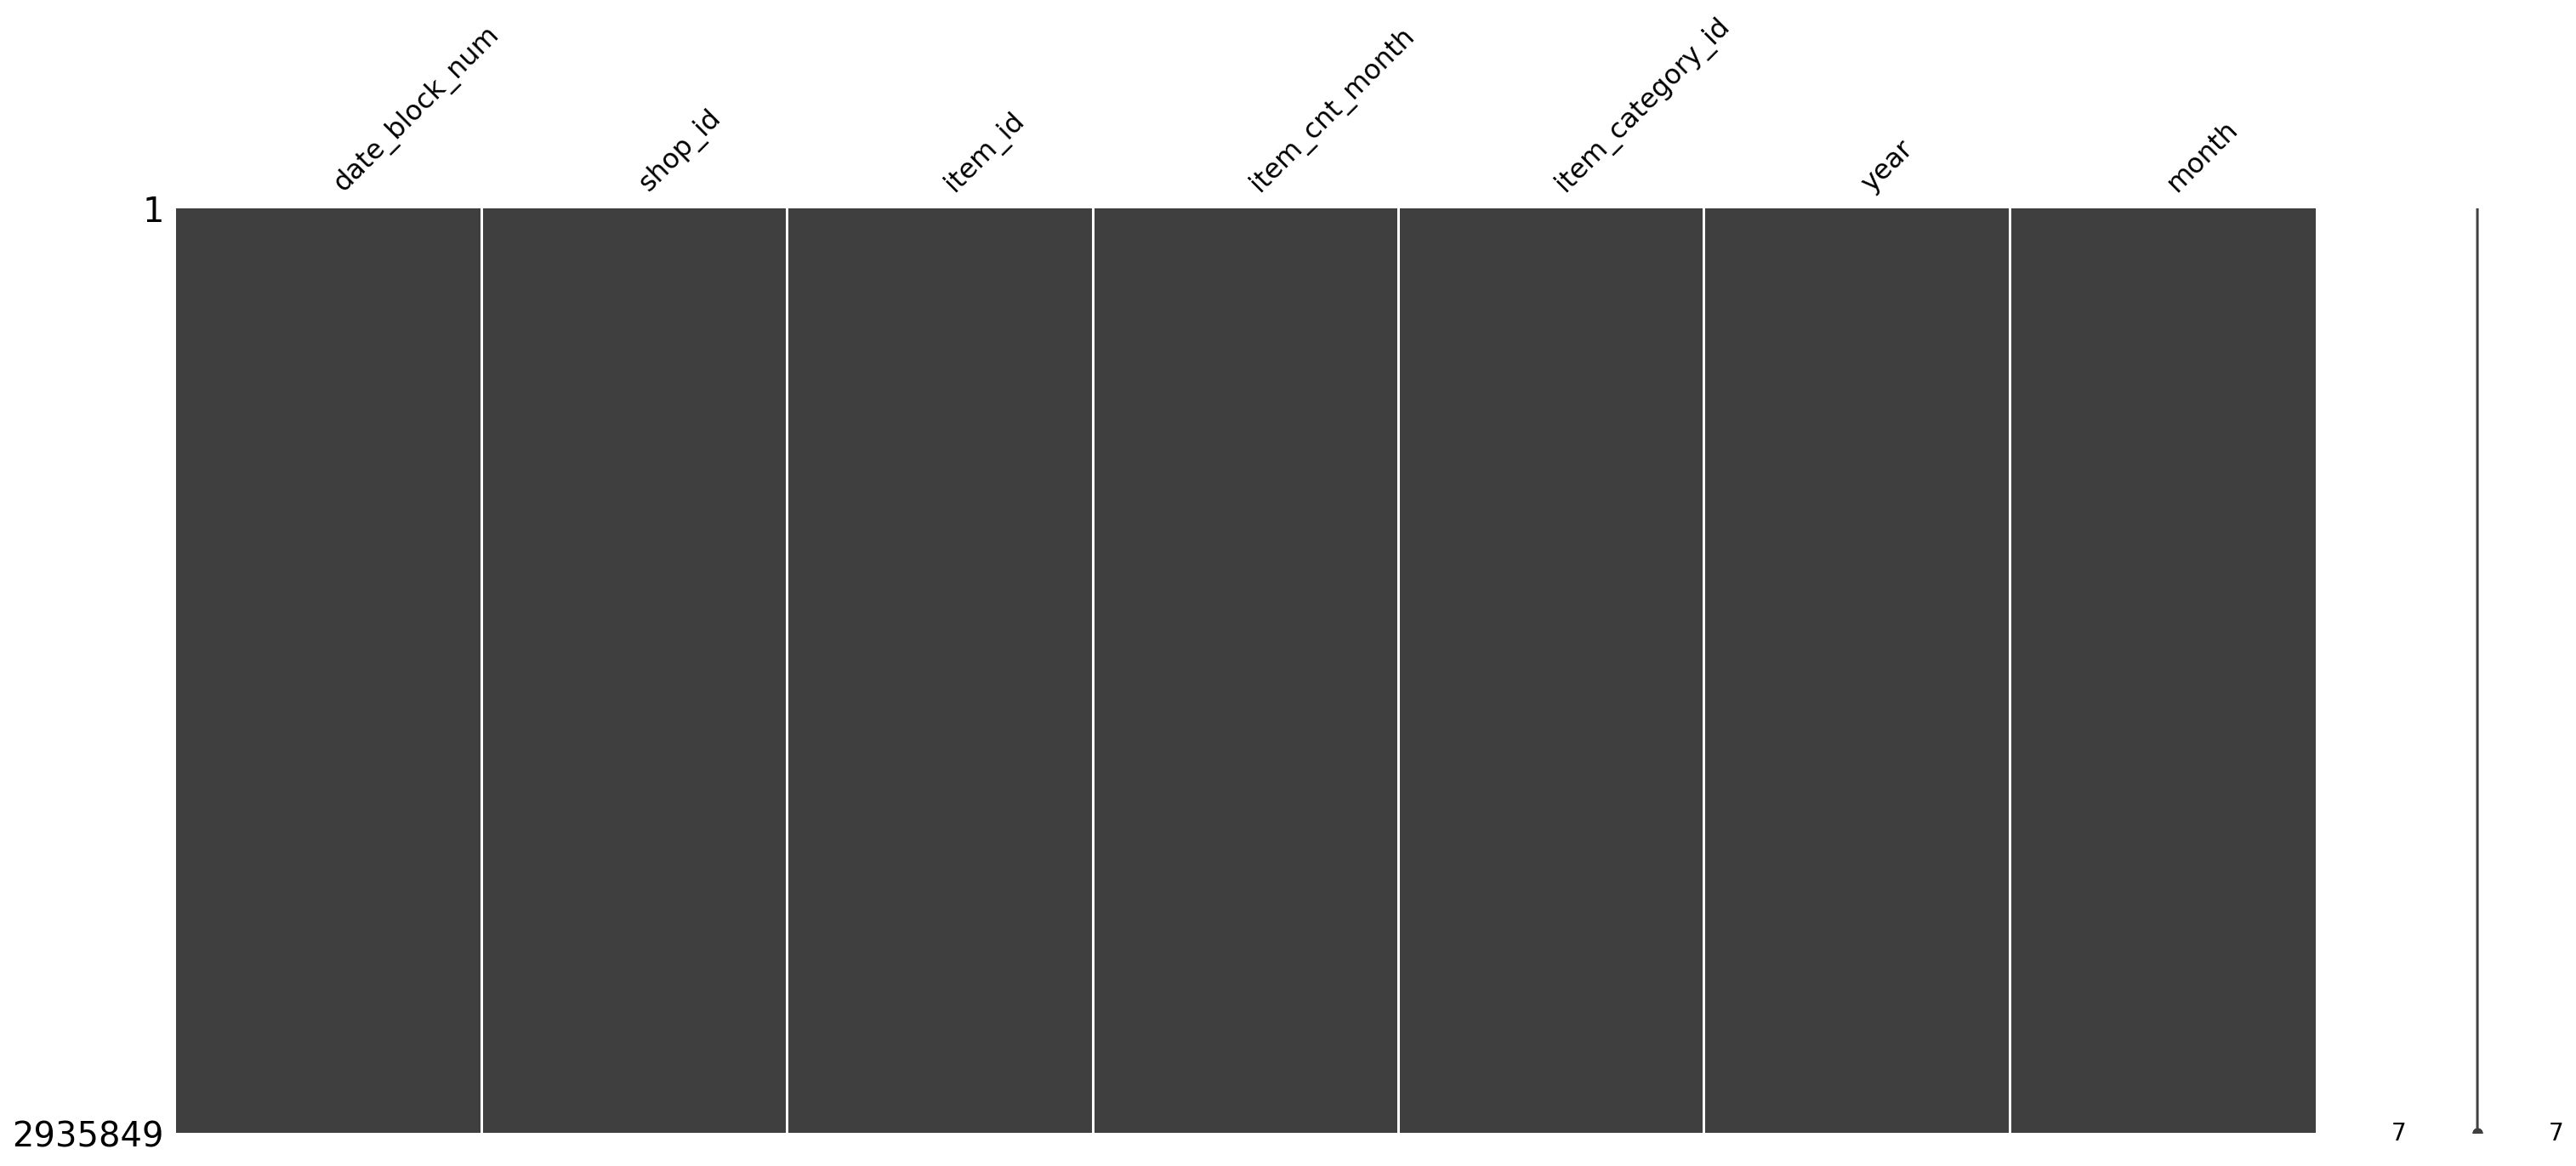

In [17]:
# 데이터 결측 상태 시각화
msno.matrix(data)

In [18]:
# 데이터 결측치 확인
for c in data.columns:
    print(f'{c}: {len(data.loc[pd.isnull(data[c]), c].values)}')

date_block_num: 0
shop_id: 0
item_id: 0
item_cnt_month: 0
item_category_id: 0
year: 0
month: 0


IndexError: index 6 is out of bounds for axis 0 with size 6

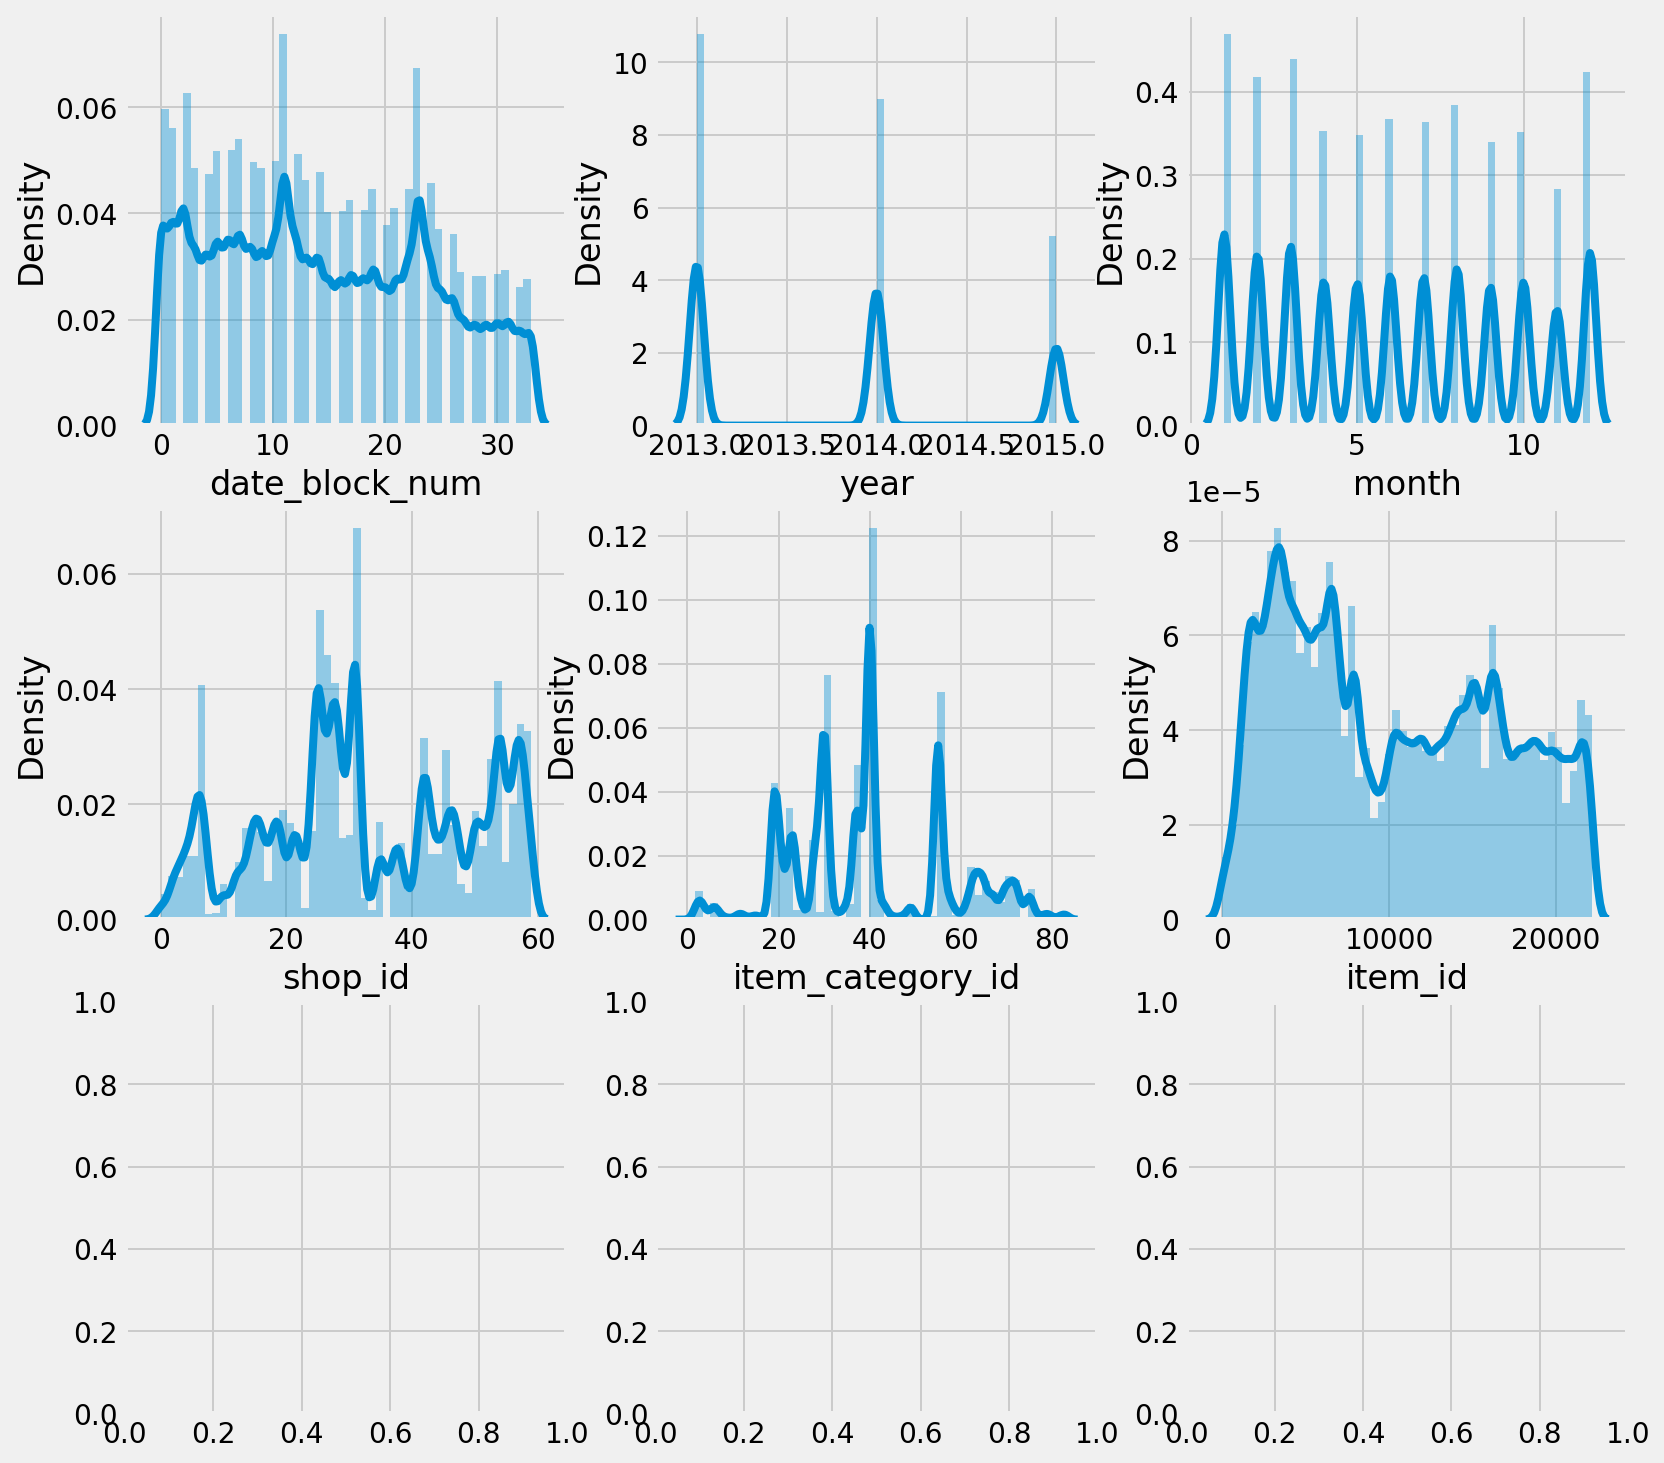

In [59]:
# 각 변수들의 분포를 확인한다.
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
count = 0
for row in range(3):
    for col in range(3):
        if count == 7:
            break
#         sns.kdeplot(data[data.columns[count]], ax=ax[row][col])
#         ax[row][col].set_title(data.columns[count], fontsize=15)
        sns.distplot(data[data.columns[count]], ax=ax[row][col])
        count += 1

In [20]:
y = data['item_cnt_month']
del data['item_cnt_month']
data = data[column_order]  # column 순서 조정
data

,date_block_num,year,month,shop_id,item_category_id,item_id
0,0,2013,1,0,40,32
1,0,2013,1,0,40,32
2,0,2013,1,0,40,32
3,0,2013,1,0,40,32
4,0,2013,1,0,37,33
...,...,...,...,...,...,...
2935844,33,2015,10,59,83,22088
2935845,33,2015,10,59,83,22088
2935846,33,2015,10,59,83,22091
2935847,33,2015,10,59,42,22100


In [21]:
# item_cnt_month 변수가 한 쪽으로 치우쳐 있으므로 로그 변환
# y = np.log(y+23)
# sns.kdeplot(y)
# plt.show()

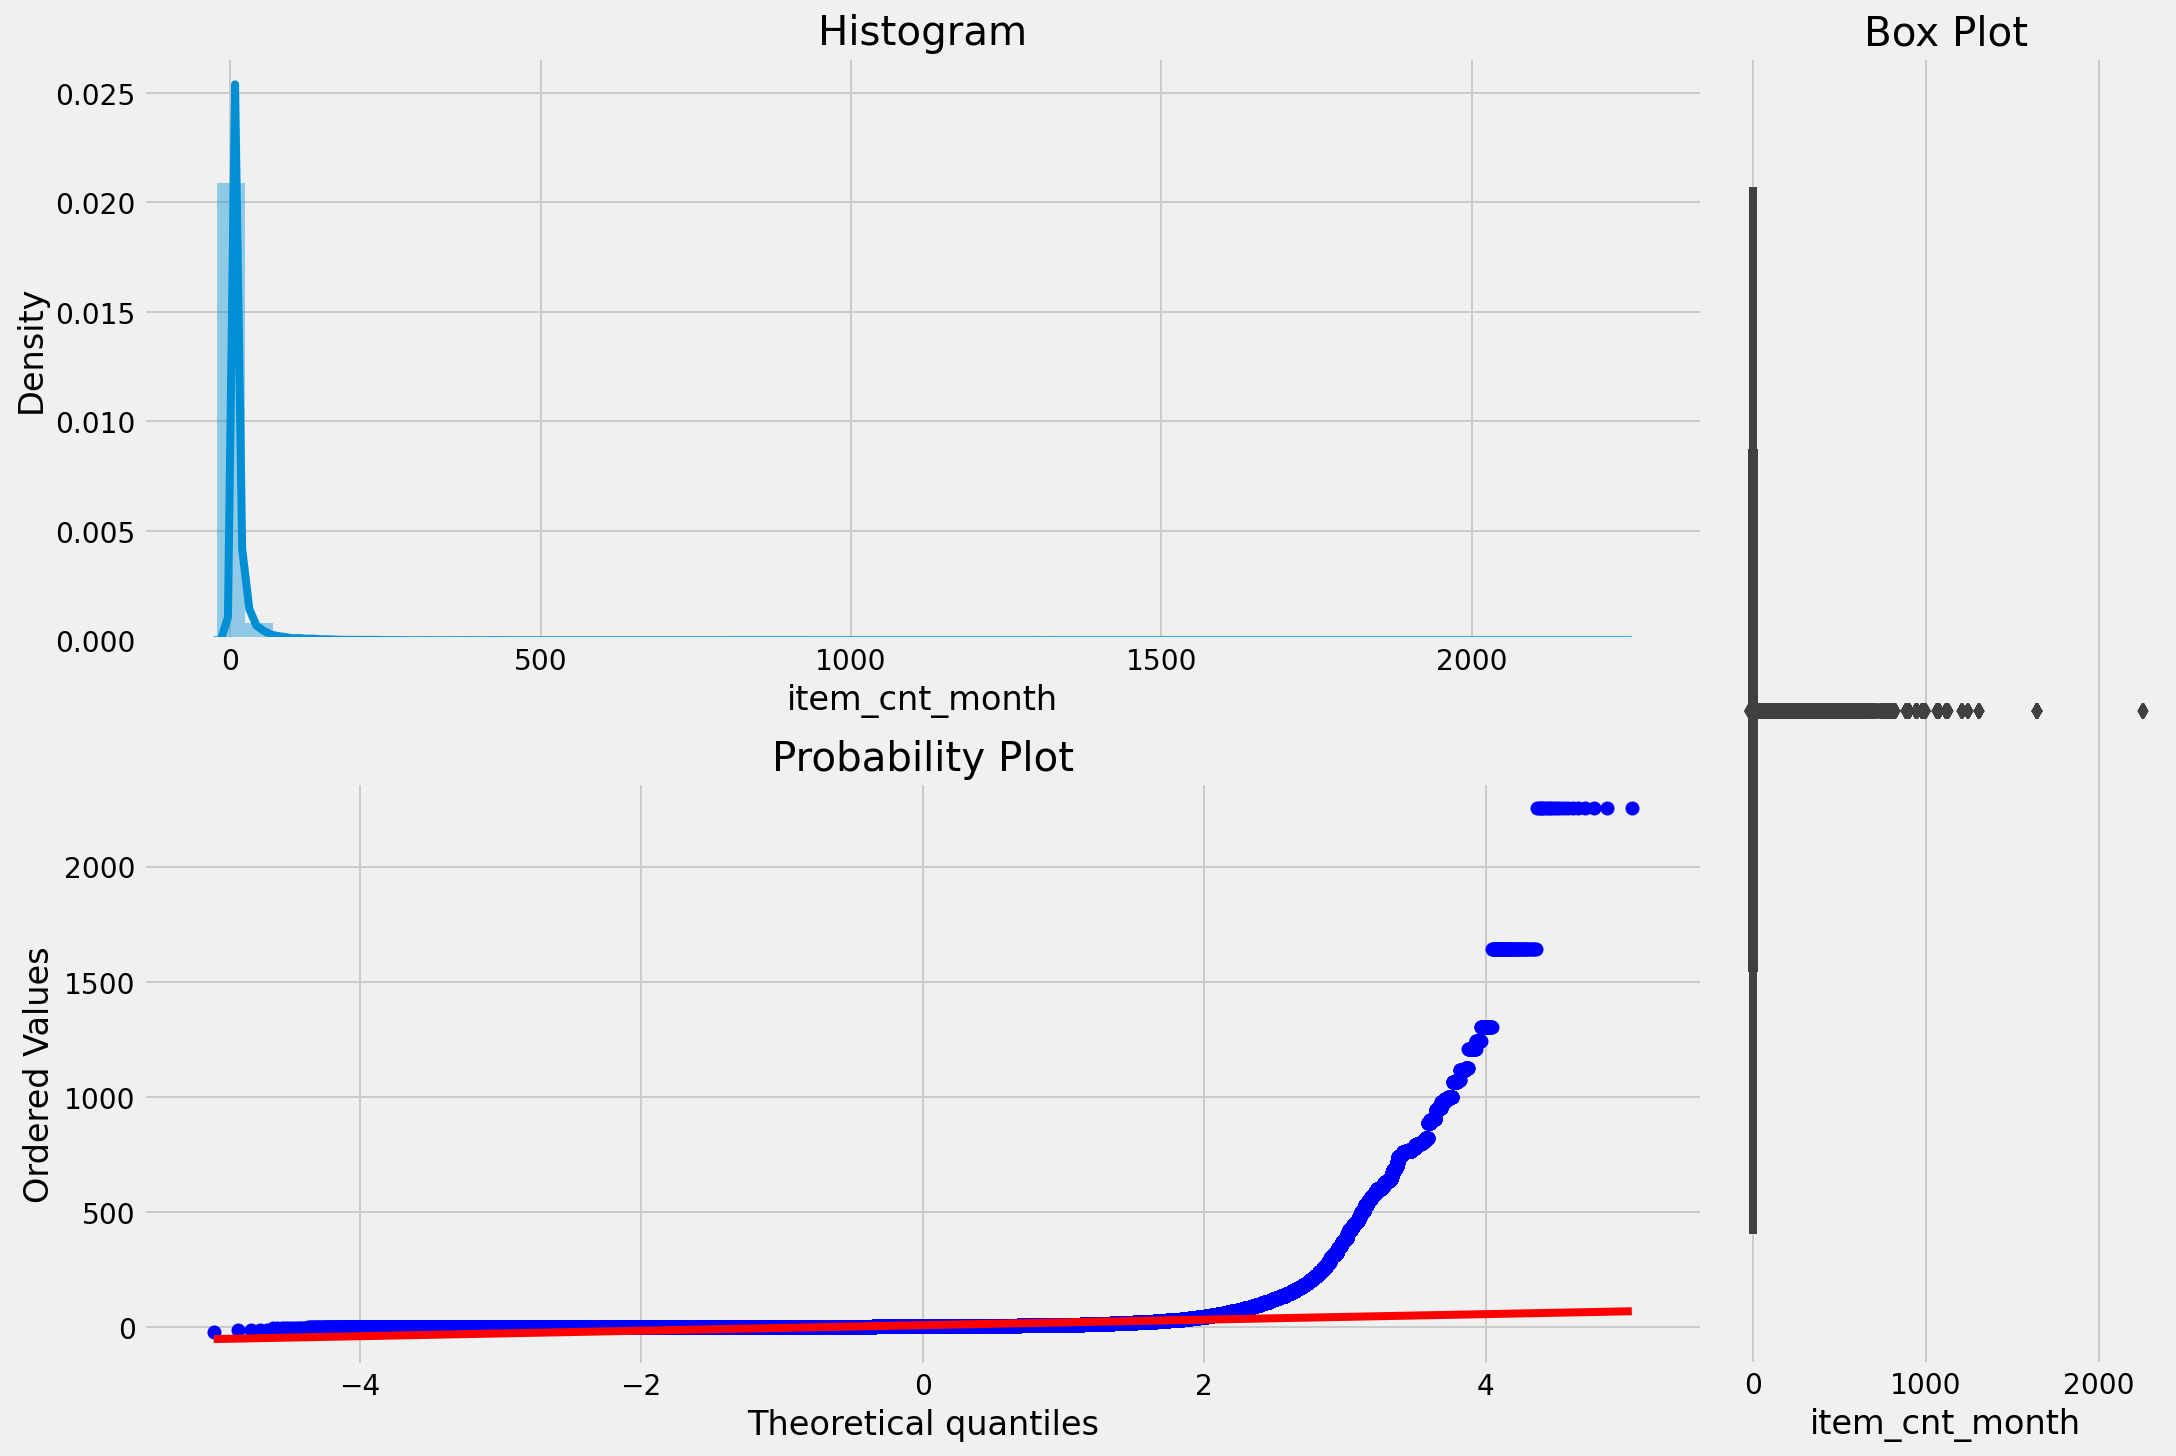

In [57]:
plotting_3_chart(pd.DataFrame(y), 'item_cnt_month')

## Test data processing

In [22]:
test_copy = test.copy()
del test_copy['ID']

# 예측할 날짜
test_copy['date_block_num'] = 34

In [23]:
test_copy['year'] = 2015
test_copy['month'] = 11

In [24]:
test_copy

,shop_id,item_id,date_block_num,year,month
0,5,5037,34,2015,11
1,5,5320,34,2015,11
2,5,5233,34,2015,11
3,5,5232,34,2015,11
4,5,5268,34,2015,11
...,...,...,...,...,...
214195,45,18454,34,2015,11
214196,45,16188,34,2015,11
214197,45,15757,34,2015,11
214198,45,19648,34,2015,11


In [25]:
# item_category_id 추가
test_copy = pd.merge(test_copy, items, on='item_id', how='left')
del test_copy['item_name']
test_copy

,shop_id,item_id,date_block_num,year,month,item_category_id
0,5,5037,34,2015,11,19
1,5,5320,34,2015,11,55
2,5,5233,34,2015,11,19
3,5,5232,34,2015,11,23
4,5,5268,34,2015,11,20
...,...,...,...,...,...,...
214195,45,18454,34,2015,11,55
214196,45,16188,34,2015,11,64
214197,45,15757,34,2015,11,55
214198,45,19648,34,2015,11,40


In [26]:
# column 순서 수정
test_copy = test_copy[column_order]
test_copy

,date_block_num,year,month,shop_id,item_category_id,item_id
0,34,2015,11,5,19,5037
1,34,2015,11,5,55,5320
2,34,2015,11,5,19,5233
3,34,2015,11,5,23,5232
4,34,2015,11,5,20,5268
...,...,...,...,...,...,...
214195,34,2015,11,45,55,18454
214196,34,2015,11,45,64,16188
214197,34,2015,11,45,55,15757
214198,34,2015,11,45,40,19648


In [27]:
# 데이터 결측치 확인
for c in test_copy.columns:
    print(f'{c}: {len(test_copy.loc[pd.isnull(test_copy[c]), c].values)}')

date_block_num: 0
year: 0
month: 0
shop_id: 0
item_category_id: 0
item_id: 0


# Model testing and selection

In [28]:
# data nomarlization을 위해
transformer = Normalizer().fit(data)

In [29]:
# RMSE
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [30]:
# models
# gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state,
                       gpu_id=0,
                       tree_method='gpu_hist',
                       predictor='gpu_predictor')
lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
sgd = SGDRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest, sgd]
models = [sgd, lightgbm, xgboost]

In [31]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(
            train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values(
            'RMSE', ascending=False)

    return score_df

In [32]:
# get_scores(models, transformer.transform(data), y)
# get_scores([xgboost], data, y)

# Hyper parameter tuning

## GridSearchCV

In [33]:
def my_GridSearch(model, train, y, param_grid, verbose=1, n_jobs=8):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              n_jobs=n_jobs,
                              cv=5,
                              verbose=verbose)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-results['score'])
    results = results.sort_values('RMSLE')

    return results

In [34]:
param_grid = [{
    'eta': [0.01],  # 보통 0.01~0.2
    'max_depth':[7]  # 보통 3~10
}]

In [35]:
my_GridSearch(xgboost, transformer.transform(data), y, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   13.0s remaining:   19.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   13.3s finished


,eta,max_depth,score,RMSLE
0,0.01,7,-598.93821,24.473214


## RandomizedSearchCV

In [36]:
# distributions = {
#     'eta': [0.01, 0.05, 0.1, 0.15, 0.2],  # 일반적으로 0.01~0.2
#     'max_depth': randint(low=3, high=10)  # 보통 3~10
# }

# rnd_search = RandomizedSearchCV(xgboost,
#                                 distributions,
#                                 scoring='neg_mean_squared_error',
#                                 random_state=0)

In [37]:
# rnd_search.fit(transformer.transform(data), y)

In [38]:
# cvres = rnd_search.cv_results_
# for mean_score, params in zip(cvres["men_test_score"], cvres["params"]):
#     print(np.sqrt(-mean_score), params)

# Submission

In [39]:
xgboost = XGBRegressor(random_state=random_state,
                       gpu_id=0,
                       tree_method='gpu_hist',
                       predictor='gpu_predictor',
                       eta=0.01,
                       max_depth=7)

In [40]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
#     prediction = np.exp(prediction)-23
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['item_cnt_month'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(
        data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [41]:
transformer_test = Normalizer().fit(test_copy)

In [43]:
save_submission(xgboost, transformer.transform(data), y,
                transformer.transform(test_copy), 'xgboost', rmsle='24.473214')

/home/aiffel-dj61/aiffel/kaggle_predict_future_sales/data/submission_xgboost_RMSLE_24.473214.csv saved!
